In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F
from torchvision.utils import make_grid

from swadist.data.loader import get_dataloaders
from swadist.utils import Trainer, show_imgs, LinearPolyLR
from swadist.models.resnet import ResNet

plt.rcParams["savefig.bbox"] = 'tight'
torch.multiprocessing.set_sharing_strategy('file_system')

torch.__version__

'1.10.2'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cpu


In [3]:
# load CIFAR-10
train_loader, valid_loader, test_loader = get_dataloaders(
    dataset="cifar10", num_workers=4, batch_size=16, cuda=device=='cuda'
)

Files already downloaded and verified
Files already downloaded and verified


Training set size: 50000
Validation set size: 50000
Test set size: 10000


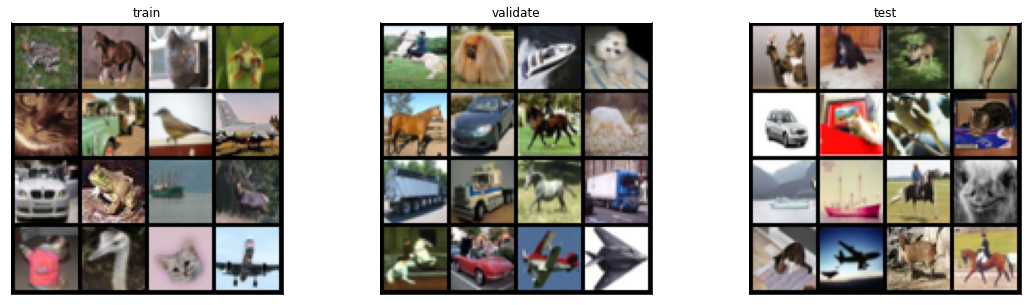

In [4]:
train_data = next(iter(train_loader))
train_grid = make_grid(train_loader.dataset.inv_transform(train_data[0]), nrow=4)

valid_data = next(iter(valid_loader))
valid_grid = make_grid(valid_loader.dataset.inv_transform(valid_data[0]), nrow=4)

test_data = next(iter(test_loader))
test_grid = make_grid(test_loader.dataset.inv_transform(test_data[0]), nrow=4)

show_imgs([train_grid, valid_grid, test_grid], titles=['train', 'validate', 'test'])
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(valid_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

In [8]:
# ~ optimal hyperparms from Shallue et al. 2019 [arXiv: 1811.03600]

# initial lr, scaling factor, momentum
lr0, alpha, gamma = 2**-8.5, 0.25, 0.97

# epochs, lr scaling epochs
epochs, decay_epochs = 4, 3
# epochs, decay_epochs = 1, 1

stopping_acc=0.9

# model
resnet8 = ResNet(in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)

optimizer = torch.optim.SGD(resnet8.parameters(), lr=lr0, momentum=gamma, nesterov=True)
scheduler = LinearPolyLR(optimizer, alpha=alpha, decay_epochs=decay_epochs, verbose=True)

# begin training
trainer = Trainer(resnet8, F.cross_entropy, optimizer, scheduler, log=True, name='sgd')
trainer(train_loader, valid_loader, epochs=epochs, stopping_acc=stopping_acc, validations_per_epoch=4)

Adjusting learning rate of group 0 to 2.7621e-03.
Starting 4-epoch training loop...

Train epoch: 1 -- Accuracy: 0.366357 -- Avg. loss (cross_entropy): 1.695245 -- Batch: 2813/2813 (100%) -- Total steps: 3955079
Validation accuracy: 0.491613 -- Avg. loss (cross_entropy): 1.416435 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 6.9053e-04.
Train epoch: 2 -- Accuracy: 0.540459 -- Avg. loss (cross_entropy): 1.262863 -- Batch: 2813/2813 (100%) -- Total steps: 3957892
Validation accuracy: 0.589257 -- Avg. loss (cross_entropy): 1.162991 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 6.9053e-04.
Train epoch: 3 -- Accuracy: 0.593872 -- Avg. loss (cross_entropy): 1.125865 -- Batch: 2813/2813 (100%) -- Total steps: 3960705
Validation accuracy: 0.611821 -- Avg. loss (cross_entropy): 1.105210 -- Batch: 313/313 (100%)

Adjusting learning rate of group 0 to 6.9053e-04.
Train epoch: 4 -- Accuracy: 0.625822 -- Avg. loss (cross_entropy): 1.041452 -- Batch: 2813/2813 (10

In [9]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

labels = []
preds = []

with torch.inference_mode():
    for data in test_loader:
        images, target = data
        labels.append(target.numpy())
        outputs = resnet8(images)
        _, predictions = torch.max(outputs, 1)
        preds.append(predictions)
        total += target.size(0)
        correct += (predictions == target).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Test accuracy: {100 * correct // total}%')
            
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

labels = pd.Series(np.hstack(labels).astype(int), name="Labels")
preds = pd.Series(np.hstack(preds).astype(int), name="Preds")
df_confusion = pd.crosstab(classes[labels], classes[preds])
df_confusion

Test accuracy: 62%
Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 74.6 %
Accuracy for class: bird  is 49.4 %
Accuracy for class: cat   is 45.7 %
Accuracy for class: deer  is 64.7 %
Accuracy for class: dog   is 59.3 %
Accuracy for class: frog  is 58.1 %
Accuracy for class: horse is 66.3 %
Accuracy for class: ship  is 69.3 %
Accuracy for class: truck is 67.1 %


col_0  bird  car  cat  deer  dog  frog  horse  plane  ship  truck
row_0                                                            
bird    494    0   68   177   93    56     37     63    11      1
car       8  746   37    19    8     4     16     70    21     71
cat      99    3  457    87  241    44     39     24     4      2
deer     71    1   70   647   53    30     96     22    10      0
dog      71    0  193    70  593    12     53      5     2      1
frog     75    2  100   182   38   581     10     10     2      0
horse    62    1   42   119   98     2    663     11     0      2
plane   103   14   27    23   14     7     16    716    65     15
ship     34   25   28    11    8     6     12    169   693     14
truck    10   90   35    28    8     1     65     60    32    671